# Assignment 3 : Sequence labelling with RNNs
In this assignement we will ask you to perform POS tagging.

You are asked to follow these steps:
*   Download the corpora and split it in training and test sets, structuring a dataframe.
*   Embed the words using GloVe embeddings
*   Create a baseline model, using a simple neural architecture
*   Experiment doing small modifications to the model
*   Evaluate your best model
*   Analyze the errors of your model

**Corpora**:
Ignore the numeric value in the third column, use only the words/symbols and its label.
https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip 

**Splits**: documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

**Baseline**: two layers architecture: a Bidirectional LSTM and a Dense/Fully-Connected layer on top.

**Modifications**: experiment using a GRU instead of the LSTM, adding an additional LSTM layer, and using a CRF in addition to the LSTM. Each of this change must be done by itself (don't mix these modifications).

**Training and Experiments**: all the experiments must involve only the training and validation sets.

**Evaluation**: in the end, only the best model of your choice must be evaluated on the test set. The main metric must be F1-Macro computed between the various part of speech (without considering punctuation classes).

**Error Analysis** (optional) : analyze the errors done by your model, try to understand which may be the causes and think about how to improve it.

**Report**: You are asked to deliver a small report of about 4-5 lines in the .txt file that sums up your findings.

In [1]:
%autosave 1
import os
import re
import numpy as np
from matplotlib import pyplot as plt

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

import seaborn as sns

from gensim.models import KeyedVectors

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Autosaving every 1 seconds


Using TensorFlow backend.
/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pptr/.conda/envs/fastai/lib/p

### Load data

In [ ]:
# all senteces
data = []
base_dir = 'dependency_treebank/'
for filename in os.listdir(base_dir):
    with open(base_dir + 'wsj_0001.dp') as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    content = [re.sub('\s+', ' ', x) for x in content]
    # remove empty strings
    content = [x for x in content if x]
    data.append(content)

In [74]:
# splitted sentences
data = []
base_dir = 'dependency_treebank/'
for filename in os.listdir(base_dir):
    with open(base_dir + 'wsj_0001.dp') as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    content = [re.sub('\s+', ' ', x) for x in content]
    sentences = []
    sent_acc = []
    for s in content:
        if s != '':
            sent_acc.append(s)
        else:
            sentences.append(sent_acc)
            sent_acc = []
    sentences.append(sent_acc)
    data.append(sentences)

In [75]:
def split_features_labels(data):
    X = []
    y = []
    for document in data:
        X_i = []
        y_i = []
        for i in document:
            X_i.append(i.split(' ')[0])
            y_i.append(i.split(' ')[1])
        X.append(X_i)
        y.append(y_i)
    return X, y

In [76]:
X, y = split_features_labels(data[:100])

AttributeError: 'list' object has no attribute 'split'

In [33]:
y[0]

['NNP',
 'NNP',
 'NNP',
 'VBD',
 'PRP',
 'VBD',
 'PRP$',
 '$',
 'CD',
 'CD',
 'JJ',
 'NN',
 'IN',
 'RB',
 'VBN',
 'NNP',
 'NNP',
 'NNP',
 ',',
 'DT',
 'NNP',
 'NN',
 'VBG',
 'NN',
 '.']

### Vectorize training data

In [5]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X)
X_encoded = word_tokenizer.texts_to_sequences(X)

In [6]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(y)
y_encoded = tag_tokenizer.texts_to_sequences(y)

In [7]:
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['First', 'Chicago', 'Corp.', 'said', 'it', 'completed', 'its', '$', '55.1', 'million', 'cash-and-stock', 'acquisition', 'of', 'closely', 'held', 'Ravenswood', 'Financial', 'Corp.', ',', 'another', 'Chicago', 'bank', 'holding', 'company', '.'] 

Y:  ['NNP', 'NNP', 'NNP', 'VBD', 'PRP', 'VBD', 'PRP$', '$', 'CD', 'CD', 'JJ', 'NN', 'IN', 'RB', 'VBN', 'NNP', 'NNP', 'NNP', ',', 'DT', 'NNP', 'NN', 'VBG', 'NN', '.'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [102, 156, 94, 15, 16, 1003, 36, 17, 3539, 35, 3540, 1004, 5, 1005, 403, 3541, 192, 94, 2, 196, 156, 146, 522, 42, 3] 

Y:  [3, 3, 3, 10, 17, 10, 22, 25, 9, 9, 6, 1, 2, 12, 16, 3, 3, 3, 7, 4, 3, 1, 18, 1, 8] 



### Pad sequences

In [8]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 4534


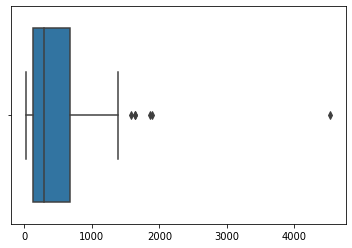

In [9]:
sns.boxplot(lengths)
plt.show()

In [10]:
MAX_SEQ_LENGTH = 2300  # sequences greater than 2300 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
y_padded = pad_sequences(y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [11]:
print(X_padded[0], "\n"*3)
print(y_padded[0])

[  0   0   0 ... 522  42   3] 



[ 0  0  0 ... 18  1  8]


In [12]:
X, y = X_padded, y_padded

In [13]:
X.shape, y.shape

((100, 2300), (100, 2300))

### Load GloVe model

In [15]:
import gensim.downloader as gloader

def load_embedding_model(model_type, embedding_dimension=50):
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """

    download_path = ""
    '''
    # Find the correct embedding model name
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"
    '''
    if model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)

    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove")

    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

In [16]:
embedding_model_type = "glove"
embedding_dimension = 50
embedding_model = load_embedding_model(embedding_model_type, embedding_dimension)

In [17]:
embedding_model.most_similar(positive = ["king", "woman"], negative = ["man"])

[('queen', 0.8523603677749634),
 ('throne', 0.7664334177970886),
 ('prince', 0.759214460849762),
 ('daughter', 0.7473883032798767),
 ('elizabeth', 0.7460220456123352),
 ('princess', 0.7424569725990295),
 ('kingdom', 0.7337411642074585),
 ('monarch', 0.7214490175247192),
 ('eldest', 0.7184861898422241),
 ('widow', 0.7099430561065674)]

### Build embedding matrix

In [18]:
def build_vocabulary(df):
    X, y = split_features_labels(df)
    flat_list = [item for sublist in X for item in sublist]
    vocab = set(flat_list)
    vocab_dict = {} # word to index
    current_index = 0
    for v in vocab:
        vocab_dict[v] = current_index
        current_index += 1
    
    voc_index_to_word = {v: k for k, v in vocab_dict.items()}
    
    return voc_index_to_word, vocab_dict, np.array(list(vocab_dict.keys()))
 


# Testing
idx_to_word, word_to_idx, word_listing = build_vocabulary(data[:100]) # only training

In [19]:
def check_OOV_terms(embedding_model, word_listing):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    
    model_vocab_array = np.array(list(embedding_model.vocab.keys()))
    return list(np.setdiff1d(word_listing, model_vocab_array))

oov_terms = check_OOV_terms(embedding_model, word_listing)

In [20]:
print("Total OOV terms: {0} ({1:.2f}%)".format(len(oov_terms), float(len(oov_terms)) / len(word_listing)))

Total OOV terms: 2258 (0.28%)


In [21]:
def build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, oov_terms, consider_oov=True):
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param oov_terms: list of OOV terms (list)
    :param co_occorruence_count_matrix: the co-occurrence count matrix of the given dataset (window size 1)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    words = np.array(list(word_to_idx.keys()))
    embedding_matrix = np.zeros((len(words), embedding_dimension))    
    for idx, w in enumerate(words):
        if w not in oov_terms:
            embedding_matrix[idx, :] = np.array(embedding_model.wv[w])
        elif consider_oov == True and idx < len(words) and idx > 0:
                # get the first 2 word in the vocab close to the current word index
                below_idx = -1
                up_idx = -1
                model_vocab = list(embedding_model.vocab.keys())

                for i in range(idx + 1, len(words)):
                    if idx_to_word[i] in model_vocab:
                        below_idx = i
                        up_idx = i
                        break

                for k in reversed(range(0, idx - 1)):
                    if idx_to_word[k] in model_vocab:
                        up_idx = k
                        below_idx = k
                        break

                up_embed = np.array(embedding_model.wv[idx_to_word[up_idx]])
                below_embed = np.array(embedding_model.wv[idx_to_word[below_idx]])
                mean_oov_word = np.mean((up_embed, below_embed), axis=0)
                embedding_matrix[idx, :] = mean_oov_word
    if consider_oov == False:
        # delete all the cells that have all values zeros, this because these
        # rows has not been initialized since we did not condier the oov terms
        embedding_matrix =  embedding_matrix[np.all(embedding_matrix != 0, axis=1)]
    return embedding_matrix

# Testing
embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, oov_terms)

print("Embedding matrix shape: {}".format(embedding_matrix.shape))

/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Embedding matrix shape: (8068, 50)


In [153]:
# let's look at an embedding of a word
#embedding_matrix[word_tokenizer.word_index['home']]

In [22]:
y = to_categorical(y)

In [23]:
y.shape

(100, 2300, 46)

# vanilla RNN

In [25]:
# total number of tags
num_classes = y.shape[2]
#vocabulary_size = len(word_tokenizer.word_index) + 1
vocabulary_size = embedding_matrix.shape[0]

In [176]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  embedding_matrix.shape[0],         # vocabulary size - number of unique words in data
                        output_dim    =  embedding_dimension,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

In [177]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [178]:
rnn_training = rnn_model.fit(X, y, batch_size=128, epochs=10)

Epoch 1/10
100/100 [==============================] - 4s 36ms/step - loss: 4.1239 - acc: 0.0052
Epoch 2/10
100/100 [==============================] - 4s 36ms/step - loss: 3.8134 - acc: 0.0058
Epoch 3/10
100/100 [==============================] - 4s 35ms/step - loss: 3.6521 - acc: 0.0059
Epoch 4/10
100/100 [==============================] - 4s 41ms/step - loss: 3.5530 - acc: 0.0058
Epoch 5/10
100/100 [==============================] - 6s 61ms/step - loss: 3.4469 - acc: 0.0058
Epoch 6/10
100/100 [==============================] - 7s 71ms/step - loss: 3.3256 - acc: 0.0119
Epoch 7/10
100/100 [==============================] - 5s 47ms/step - loss: 3.1969 - acc: 0.7962
Epoch 8/10
100/100 [==============================] - 4s 38ms/step - loss: 3.0637 - acc: 0.7944
Epoch 9/10
100/100 [==============================] - 3s 33ms/step - loss: 2.9289 - acc: 0.7911
Epoch 10/10
100/100 [==============================] - 4s 35ms/step - loss: 2.7913 - acc: 0.7907


## LSTM

In [173]:
# create architecture

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = vocabulary_size,         # vocabulary size - number of unique words in data
                         output_dim    = embedding_dimension,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embedding_matrix],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

In [174]:
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])

In [175]:
lstm_training = lstm_model.fit(X, y, batch_size=128, epochs=10)

/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
100/100 [==============================] - 9s 87ms/step - loss: 3.8293 - acc: 0.7944
Epoch 2/10
100/100 [==============================] - 9s 92ms/step - loss: 3.7977 - acc: 0.8040
Epoch 3/10
100/100 [==============================] - 16s 163ms/step - loss: 3.7641 - acc: 0.8164
Epoch 4/10
100/100 [==============================] - 11s 105ms/step - loss: 3.7263 - acc: 0.8243
Epoch 5/10
100/100 [==============================] - 10s 99ms/step - loss: 3.6819 - acc: 0.8290
Epoch 6/10
100/100 [==============================] - 9s 92ms/step - loss: 3.6282 - acc: 0.8316
Epoch 7/10
100/100 [==============================] - 10s 105ms/step - loss: 3.5618 - acc: 0.8329
Epoch 8/10
100/100 [==============================] - 11s 106ms/step - loss: 3.4779 - acc: 0.8336
Epoch 9/10
100/100 [==============================] - 9s 92ms/step - loss: 3.3693 - acc: 0.8339
Epoch 10/10
100/100 [==============================] - 9s 95ms/step - loss: 3.2251 - acc: 0.8340


## Baseline - Bidirectional LSTM

In [26]:
# create architecture

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = vocabulary_size,
                             output_dim    = embedding_dimension,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_matrix],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

In [27]:
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [29]:
bidirect_training = bidirect_model.fit(X, y, batch_size=128, epochs=50)

Epoch 1/50
100/100 [==============================] - 15s 150ms/step - loss: 1.1513 - acc: 0.7908
Epoch 2/50
100/100 [==============================] - 14s 137ms/step - loss: 1.0594 - acc: 0.7907
Epoch 3/50
100/100 [==============================] - 14s 139ms/step - loss: 0.9899 - acc: 0.7907
Epoch 4/50
100/100 [==============================] - 14s 139ms/step - loss: 0.9379 - acc: 0.7907
Epoch 5/50
100/100 [==============================] - 14s 140ms/step - loss: 0.8991 - acc: 0.7907
Epoch 6/50
100/100 [==============================] - 14s 139ms/step - loss: 0.8700 - acc: 0.7907
Epoch 7/50
100/100 [==============================] - 14s 140ms/step - loss: 0.8479 - acc: 0.7908
Epoch 8/50
100/100 [==============================] - 14s 140ms/step - loss: 0.8308 - acc: 0.7908
Epoch 9/50
100/100 [==============================] - 14s 142ms/step - loss: 0.8170 - acc: 0.7908
Epoch 10/50
100/100 [==============================] - 14s 141ms/step - loss: 0.8054 - acc: 0.7908
Epoch 11/50
100/100

In [ ]:
# use Keras' to_categorical function to one-hot encode Y
y = to_categorical(y)

X_train, y_train = X[:100, :], y[:100, :, :]
X_val, y_val = X[100:150, :], y[100:150, :, :]
X_test, y_test = X[150:, :], y[150:, :, :]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape